In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [16]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0.6, max=0.9)
    return x


In [17]:
N_Agents = 1
in_dim = 1
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 2
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [19]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    #return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    return np.where((x > 0.6) & (x < 0.9),3, 0)

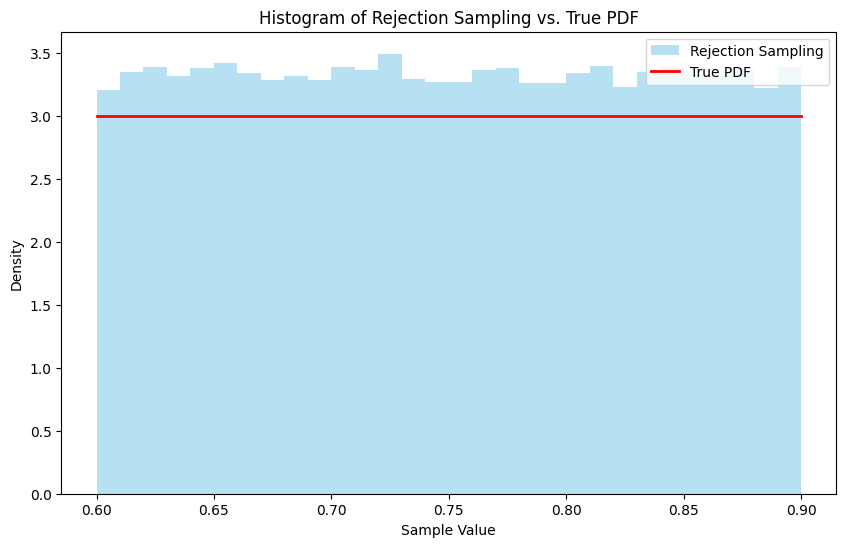

tensor([ 1.0000, -0.9631]) target distribution


In [20]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 5/3, num_samples = 100000)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)

In [21]:
optimizer_lbfgs = optim.LBFGS(model.parameters(), line_search_fn = 'strong_wolfe')

TypeError: function() takes 0 positional arguments but 1 was given

per iter: 13.088719844818115 total time: 5235.487937927246
Epoch [1/50], Loss: 3.968334
Epoch [2/50], Loss: 3.960152
Epoch [3/50], Loss: 3.911351
Epoch [4/50], Loss: 3.894448
Epoch [5/50], Loss: 3.921826
Epoch [6/50], Loss: 3.924940
Epoch [7/50], Loss: 3.924329
Epoch [8/50], Loss: 3.925095
Epoch [9/50], Loss: 3.925997
Epoch [10/50], Loss: 3.924170
Epoch [11/50], Loss: 3.924566
Epoch [12/50], Loss: 3.925863
Epoch [13/50], Loss: 3.931320
Epoch [14/50], Loss: 3.930397
Epoch [15/50], Loss: 3.929090
Epoch [16/50], Loss: 3.929741
Epoch [17/50], Loss: 3.929338
Epoch [18/50], Loss: 3.928247
Epoch [19/50], Loss: 3.930135
Epoch [20/50], Loss: 3.791471
Epoch [21/50], Loss: 3.622982
Epoch [22/50], Loss: 3.601452
Epoch [23/50], Loss: 3.598179
Epoch [24/50], Loss: 3.595683
Epoch [25/50], Loss: 3.602416
Epoch [26/50], Loss: 3.590609
Epoch [27/50], Loss: 3.593908
Epoch [28/50], Loss: 3.586536
Epoch [29/50], Loss: 3.598684
Epoch [30/50], Loss: 3.593713
Epoch [31/50], Loss: 3.597277
Epoch [32/50], Loss:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [50/50], Loss: 3.516035


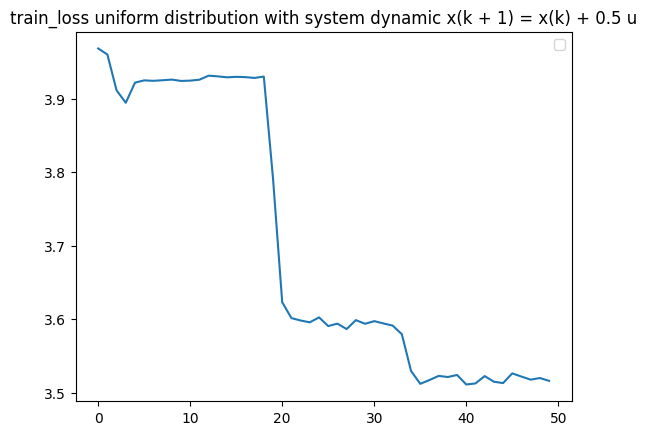

Training Complete!


In [22]:
import time
criterion.verbose = False
epochs = 50  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        inputs = gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim)
        def closure():
            model.init_hidden(batch_size = batch_size)
            optimizer_lbfgs.zero_grad()
            outputs, control = model(inputs)
            loss = criterion(x = outputs, u = control) + model.penalty
            loss.backward()
            return loss
        optimizer_lbfgs.step(closure)
        with torch.no_grad():
            model.init_hidden(batch_size = batch_size)
            control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
            loss = criterion(x = outputs, u = control) + model.penalty
        running_loss += loss.item()
        if show:
            show = False
            criterion.verbose = False
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


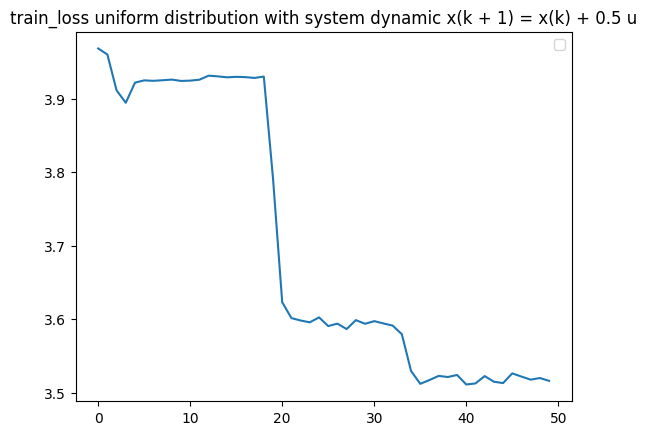

Training Complete!


In [23]:
plt.plot(train_loss[-300:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

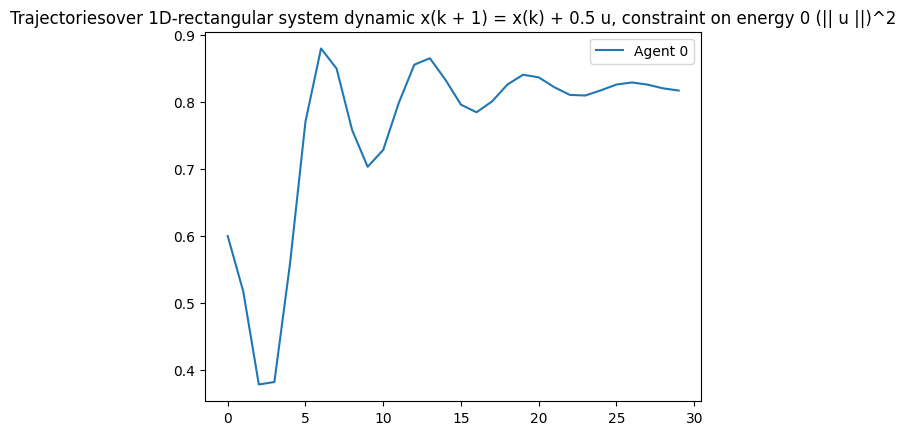

In [24]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()



In [25]:
#import Ergodic_Loss
#import sys
#sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
#import importlib
#importlib.reload(Ergodic_Loss)
#criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

model: tensor(-0.9631, grad_fn=<SelectBackward0>) target: tensor(-0.9631)


tensor(2.9802e-08, grad_fn=<AddBackward0>)

In [26]:
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion(x = outs, u = control)

model: tensor(-0.9631, grad_fn=<SelectBackward0>) target: tensor(-0.9631)


tensor(2.9802e-08, grad_fn=<AddBackward0>)